In [1]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, conlist, field_validator, ValidationError, model_validator
from typing import List, Dict, Optional, Any, Union
import pandas as pd
import geojson
import geopandas as gpd
from shapely.geometry import shape, Polygon
from shapely.ops import split, unary_union
import matplotlib.pyplot as plt

In [2]:
with open('geojson_ex.json') as f:
    geojson_data = geojson.load(f)

In [3]:
# Parse building limits
building_limits = geojson_data["building_limits"]["features"]
building_geometries = [shape(feature["geometry"]) for feature in building_limits]

# Parse height plateaus
height_plateaus = geojson_data["height_plateaus"]["features"]
height_geometries = [shape(feature["geometry"]) for feature in height_plateaus]
elevations = [feature["properties"]["elevation"] for feature in height_plateaus]

# Create GeoDataFrames
building_gdf = gpd.GeoDataFrame(geometry=building_geometries)
height_gdf = gpd.GeoDataFrame(geometry=height_geometries)
height_gdf["elevation"] = elevations

<Axes: >

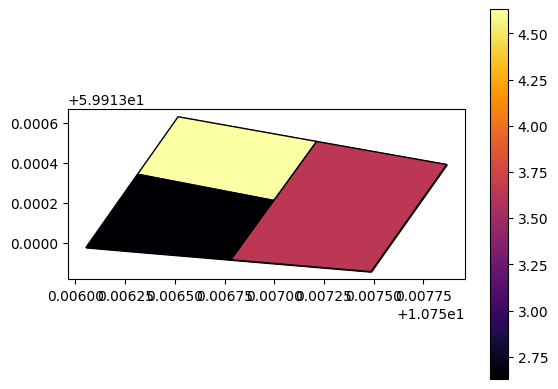

In [4]:
fig, ax = plt.subplots()
building_gdf.plot(ax=ax, color="white", edgecolor="black")
height_gdf.plot(ax=ax, column='elevation', edgecolor="black",cmap='inferno',legend=True)

In [5]:
class Geometry(BaseModel):
    type: str
    coordinates: List[conlist(conlist(float, min_length=2, max_length=2),min_length=3)]

class BuildLimit(BaseModel):
    type: str
    properties: Optional[Dict[str,Any]]
    geometry: Geometry


class HeightPlateau(BaseModel):
    type: str
    properties: Dict[str,Any]
    geometry: Geometry

    @field_validator('properties')
    def check_elevation(cls, v: Dict):
        if 'elevation' not in v:
            raise ValueError('properties must have an "elevation" key')
        if not isinstance(v['elevation'], float):
            raise TypeError('The value of "elevation" must be a float')
        return v 

class BuildLimits(BaseModel):
    type: str
    features: List[BuildLimit] 

class HeightPlateaus(BaseModel):
    type: str
    features: List[HeightPlateau]

class BuildSite(BaseModel):
    building_limits: BuildLimits
    height_plateaus: HeightPlateaus

    @model_validator(mode='before')
    def check_height_plateaus(cls, values):
        if 'height_plateaus' not in values or not values['height_plateaus']:
            raise ValueError('At least one height plateau must be provided')
        if 'building_limits' not in values or not values['building_limits']:
            raise ValueError('At least one building limit must be provided')
        return values

    def validate_site(self, tolerance: int = 6):
        building_geometries = [Polygon(feature.geometry.coordinates[0]) for feature in self.building_limits.features]
        height_geometries = [Polygon(feature.geometry.coordinates[0]) for feature in self.height_plateaus.features]

        combined_height_plateaus = unary_union(height_geometries)

        # Check if each building limit is completely covered by the height plateaus
        for i, building in enumerate(building_geometries):
            if not combined_height_plateaus.contains(building):
                intersection = combined_height_plateaus.intersection(building)
                area = round(building.difference(intersection).area,tolerance)
                if area > 0:
                    raise ValueError(f"Height plateaus do not completely cover building {i}.")
        print(f'Buildings are covered by height plateaus to {tolerance} decimal places')

        # Check for overlaps between height plateaus
        for i, height1 in enumerate(height_geometries):
            for j, height2 in enumerate(height_geometries):
                if i != j:
                    area = round(height1.intersection(height2).area,tolerance)
                    if area > 0:
                        print(area)
                        raise ValueError(f"Height plateaus {i} and {j} overlap.")
        print(f'Height plateaus do not overlap to {tolerance} decimal places')
 




class SplitBuildSite(BaseModel):
    pass

In [6]:
with open('geojson_ex2.json') as f:
    geojson_data = geojson.load(f)

site = BuildSite(**geojson_data)
site.validate_site(6)

Buildings are covered by height plateaus to 6 decimal places
Height plateaus do not overlap to 6 decimal places


In [9]:
def to_geodataframe(features):
    geometries = [Polygon(feature.geometry.coordinates[0]) for feature in features]
    return gpd.GeoDataFrame(geometry=geometries)

def buildsite_to_geodataframes(buildsite: BuildSite):
    building_limits_gdf = to_geodataframe(buildsite.building_limits.features)
    height_plateaus_gdf = to_geodataframe(buildsite.height_plateaus.features)
    height_plateaus_gdf['elevation'] =[feature.properties['elevation'] for feature in buildsite.height_plateaus.features]
    return building_limits_gdf, height_plateaus_gdf

def split_building_limits(project_name, building_limits_gdf, height_plateaus_gdf):
    output_dict = {}
    for i, b in building_limits_gdf.iterrows():
        result_gdf = gpd.GeoDataFrame()
        for _, h in height_plateaus_gdf.iterrows():
            intersection = b.geometry.intersection(h.geometry)
            # put in gdf
            if not intersection.is_empty:
                tmp = gpd.GeoDataFrame(geometry=[intersection])
                tmp['elevation'] = h['elevation']
                result_gdf = pd.concat([result_gdf,tmp]).reset_index(drop=True)
        output_dict[i] = {
            'project_name':project_name,
            'building_id':i,
            'split_building_limits':result_gdf.to_geo_dict(),
            'building_limits':gpd.GeoDataFrame(geometry=[building_limits_gdf.iloc[0].geometry]).to_geo_dict(),
            'height_plateaus':height_plateaus_gdf.to_geo_dict()
        }
    return output_dict




In [10]:
building_limits_gdf, height_plateaus_gdf = buildsite_to_geodataframes(site)
results = split_building_limits('temp',building_limits_gdf, height_plateaus_gdf)

In [12]:
import json
from decimal import Decimal

In [16]:
item = json.loads(json.dumps(results[0]), parse_float=Decimal)

In [17]:
item

{'project_name': 'temp',
 'building_id': 0,
 'split_building_limits': {'type': 'FeatureCollection',
  'features': [{'id': '0',
    'type': 'Feature',
    'properties': {'elevation': Decimal('3.63')},
    'geometry': {'type': 'Polygon',
     'coordinates': [[[Decimal('0.0'), Decimal('0.0')],
       [Decimal('0.0'), Decimal('10.0')],
       [Decimal('5.0'), Decimal('10.0')],
       [Decimal('5.0'), Decimal('0.0')],
       [Decimal('0.0'), Decimal('0.0')]]]}}]},
 'building_limits': {'type': 'FeatureCollection',
  'features': [{'id': '0',
    'type': 'Feature',
    'properties': {},
    'geometry': {'type': 'Polygon',
     'coordinates': [[[Decimal('0.0'), Decimal('0.0')],
       [Decimal('5.0'), Decimal('0.0')],
       [Decimal('5.0'), Decimal('10.0')],
       [Decimal('0.0'), Decimal('10.0')],
       [Decimal('0.0'), Decimal('0.0')]]]}}]},
 'height_plateaus': {'type': 'FeatureCollection',
  'features': [{'id': '0',
    'type': 'Feature',
    'properties': {'elevation': Decimal('3.63')},


In [19]:
from boto3.dynamodb.conditions import Key
import boto3

dynamodb = boto3.resource("dynamodb")
table_name = 'split-site-table'
table = dynamodb.Table(table_name)


partition_key_value = 'test_project'
response = table.query(KeyConditionExpression=Key('project_name').eq(partition_key_value))
items = response.get('Items',[])

In [22]:
items[0]

{'project_name': 'test_project',
 'building_limits': {'type': 'FeatureCollection',
  'features': [{'geometry': {'type': 'Polygon',
     'coordinates': [[[Decimal('0'), Decimal('0')],
       [Decimal('5'), Decimal('0')],
       [Decimal('5'), Decimal('10')],
       [Decimal('0'), Decimal('10')],
       [Decimal('0'), Decimal('0')]]]},
    'id': '0',
    'type': 'Feature',
    'properties': {}}]},
 'building_id': Decimal('0'),
 'height_plateaus': {'type': 'FeatureCollection',
  'features': [{'geometry': {'type': 'Polygon',
     'coordinates': [[[Decimal('0'), Decimal('0')],
       [Decimal('9'), Decimal('0')],
       [Decimal('9'), Decimal('10')],
       [Decimal('0'), Decimal('10')],
       [Decimal('0'), Decimal('0')]]]},
    'id': '0',
    'type': 'Feature',
    'properties': {'elevation': Decimal('3.63')}},
   {'geometry': {'type': 'Polygon',
     'coordinates': [[[Decimal('9'), Decimal('0')],
       [Decimal('11'), Decimal('0')],
       [Decimal('11'), Decimal('10')],
       [Decima

In [30]:
list(split_building_limits_dict.keys())

[0]

In [39]:
split_building_limits_dict[0]

{'building_id': 0,
 'split_building_limits':                                 geometry  elevation
 0  POLYGON ((0 0, 0 10, 5 10, 5 0, 0 0))       3.63,
 'building_limits':                                 geometry
 0  POLYGON ((0 0, 5 0, 5 10, 0 10, 0 0)),
 'height_plateaus':                                   geometry  elevation
 0    POLYGON ((0 0, 9 0, 9 10, 0 10, 0 0))       3.63
 1  POLYGON ((9 0, 11 0, 11 10, 9 10, 9 0))       2.50}

In [40]:
split_building_limits_dict[1]

{'building_id': 1,
 'split_building_limits':                                   geometry  elevation
 0    POLYGON ((5 0, 5 10, 9 10, 9 0, 5 0))       3.63
 1  POLYGON ((9 0, 9 10, 10 10, 10 0, 9 0))       2.50,
 'building_limits':                                 geometry
 0  POLYGON ((0 0, 5 0, 5 10, 0 10, 0 0)),
 'height_plateaus':                                   geometry  elevation
 0    POLYGON ((0 0, 9 0, 9 10, 0 10, 0 0))       3.63
 1  POLYGON ((9 0, 11 0, 11 10, 9 10, 9 0))       2.50}

<Axes: >

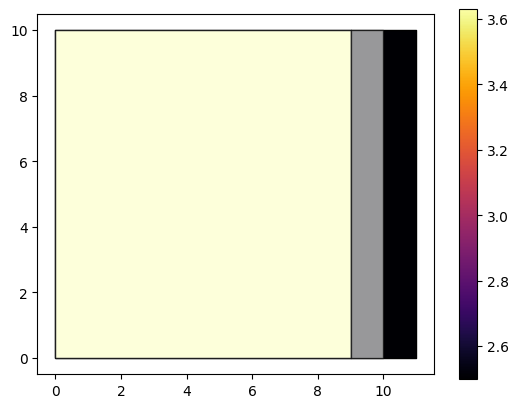

In [231]:
fig, ax = plt.subplots()
height_plateaus_gdf.plot(ax=ax, column='elevation', edgecolor="black",cmap='inferno',legend=True)
split_building_limits_dict[0].plot(ax=ax, color="white", edgecolor="black", alpha=0.6)

RuntimeError: asyncio.run() cannot be called from a running event loop

In [109]:
test = {
    "building_limits": {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "properties": {},
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [10.757867266534337, 59.91339283457274],
                            [10.756516000002959, 59.913633000004204],
                            [10.756398999995643, 59.91346700000333],
                            [10.75628300000438, 59.91330300000502],
                            [10.756052815307351, 59.91297582153187],
                            [10.756245682709302, 59.912959479672516],
                            [10.757486364709461, 59.91285434826322],
                            [10.757867266534337, 59.91339283457274]

                        ]
                    ]
                }
            },
            {
                "type": "Feature",
                "properties": {},
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [11.757867266534337, 59.91339283457274],
                            [10.756516000002959, 59.913633000004204],
                            [10.756398999995643, 59.91346700000333],
                            [10.75628300000438, 59.91330300000502],
                            [10.756052815307351, 59.91297582153187],
                            [10.756245682709302, 59.912959479672516],
                            [10.757486364709461, 59.91285434826322],
                            [10.757867266534337, 59.91339283457274]

                        ]
                    ]
                }
            },
        ]
    },
    "height_plateaus": {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [10.757867266534337, 59.91339283457274],
                            [10.756516000002959, 59.913633000004204],
                            [10.756398999995643, 59.91346700000333],
                            [10.75628300000438, 59.91330300000502],
                            [10.756052815307351, 59.91297582153187],
                            [10.756245682709302, 59.912959479672516],
                            [10.757486364709461, 59.91285434826322],
                            [10.757867266534337, 59.91339283457274]

                        ]
                    ]
                },
                "properties": {
                    "elevation": 3.63
                }
            },
            {
                "type": "Feature",
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [10.757867266534337, 59.91339283457274],
                            [10.756516000002959, 59.913633000004204],
                            [10.756398999995643, 59.91346700000333],
                            [10.75628300000438, 59.91330300000502],
                            [10.756052815307351, 59.91297582153187],
                            [10.756245682709302, 59.912959479672516],
                            [10.757486364709461, 59.91285434826322],
                            [10.757867266534337, 59.91339283457274]

                        ]
                    ]
                },
                "properties": {
                    "elevation": 3.63
                }
            },
        ]
    }
}
try:
    a = BuildSite(**test)
except ValidationError as e:
    print(e)


1 validation error for BuildSite
project_id
  Field required [type=missing, input_value={'building_limits': {'typ... {'elevation': 3.63}}]}}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.8/v/missing


In [72]:
a.building_limits.features[0].geometry.model_dump()

{'type': 'Polygon',
 'coordinates': [[[10.757867266534337, 59.91339283457274],
   [10.756516000002959, 59.913633000004204],
   [10.756398999995643, 59.91346700000333],
   [10.75628300000438, 59.91330300000502],
   [10.756052815307351, 59.91297582153187],
   [10.756245682709302, 59.912959479672516],
   [10.757486364709461, 59.91285434826322],
   [10.757867266534337, 59.91339283457274]]]}

ValueError: Height plateaus do not completely cover building 0.

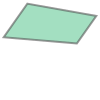

In [62]:
shape(geojson_data["building_limits"]["features"][0]["geometry"])

In [63]:
geojson_data["building_limits"]["features"][0]["geometry"]

{"coordinates": [[[10.757867, 59.913393], [10.756516, 59.913633], [10.756399, 59.913467], [10.756283, 59.913303], [10.756053, 59.912976], [10.756246, 59.912959], [10.757486, 59.912854], [10.757867, 59.913393]]], "type": "Polygon"}

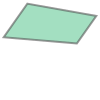

In [87]:
Polygon(building_limits.features[0].geometry.coordinates[0])

In [50]:
building_limits.features[0].geometry.coordinates

[[[10.757867, 59.913393],
  [10.756516, 59.913633],
  [10.756399, 59.913467],
  [10.756283, 59.913303],
  [10.756053, 59.912976],
  [10.756246, 59.912959],
  [10.757486, 59.912854],
  [10.757867, 59.913393]]]

In [51]:
data_model = BuildSite(**geojson_data)

building_limits = data_model.building_limits
height_plateaus = data_model.height_plateaus

# Parse building limits
building_geometries = [Polygon(build_limit.geometry.coordinates[0]) for build_limit in building_limits.features]

# Parse height plateaus
height_geometries = [Polygon(height_limit.geometry.coordinates[0]) for height_limit in height_plateaus.features]
elevations = [height_limit.properties["elevation"] for height_limit in height_plateaus.features]

# Create GeoDataFrames
building_gdf = gpd.GeoDataFrame(geometry=building_geometries)
height_gdf = gpd.GeoDataFrame(geometry=height_geometries)
height_gdf["elevation"] = elevations

def validate_geojson(building_geometries, height_geometries):
    # Combine all height plateaus into a single geometry
    combined_height_plateaus = unary_union(height_geometries)

    # Check if each building limit is completely covered by the height plateaus
    for building in building_geometries:
        if not combined_height_plateaus.contains(building):
            raise ValueError("Height plateaus do not completely cover the building limits.")

    # Check for overlaps between height plateaus
    for i, height1 in enumerate(height_geometries):
        for j, height2 in enumerate(height_geometries):
            if i != j:
                if height1.intersects(height2):
                    raise ValueError("Height plateaus overlap.")

validate_geojson(building_geometries, height_geometries)

ValueError: Height plateaus do not completely cover the building limits.

In [52]:
height_gdf

,geometry,elevation
0,"POLYGON ((10.75678 59.91291, 10.75749 59.91285...",3.63
1,"POLYGON ((10.757 59.91321, 10.75721 59.91351, ...",4.63
2,"POLYGON ((10.75631 59.91334, 10.75628 59.9133,...",2.63


In [53]:
building_gdf

,geometry
0,"POLYGON ((10.75787 59.91339, 10.75652 59.91363..."


In [91]:
building_geometries

[<POLYGON ((10.758 59.913, 10.757 59.914, 10.756 59.913, 10.756 59.913, 10.75...>]

In [89]:
building_gdf = gpd.GeoDataFrame(geometry=building_geometries)
height_gdf = gpd.GeoDataFrame(geometry=height_geometries)
height_gdf["elevation"] = elevations

<Axes: >

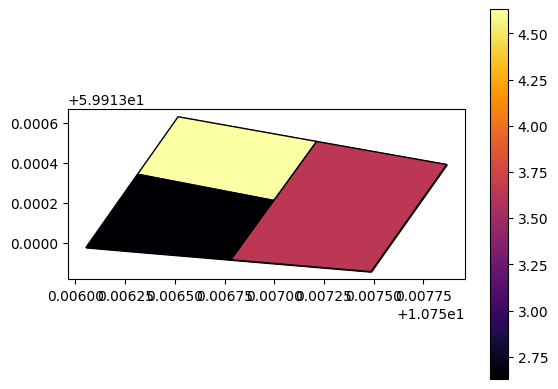

In [90]:
fig, ax = plt.subplots()
building_gdf.plot(ax=ax, color="white", edgecolor="black")
height_gdf.plot(ax=ax, column='elevation', edgecolor="black",cmap='inferno',legend=True)

In [71]:
def process_geojson(building_limits: GeoJSONFeatureCollection, height_plateaus: GeoJSONFeatureCollection):

    # Parse building limits
    building_geometries = [shape(feature.geometry) for feature in building_limits.features]

    # Parse height plateaus
    height_geometries = [shape(feature.geometry) for feature in height_plateaus.features]
    elevations = [feature.properties["elevation"] for feature in height_plateaus.features]

    # Validate the input data
    validate_geojson(building_geometries, height_geometries)

    # Split building limits by height plateaus
    split_building_limits = []
    for building in building_geometries:
        for height, elevation in zip(height_geometries, elevations):
            if building.intersects(height):
                intersection = building.intersection(height)
                if isinstance(intersection, Polygon):
                    split_building_limits.append({
                        "geometry": intersection,
                        "properties": {"elevation": elevation}
                    })

    # Store the entities
    storage["building_limits"] = building_limits.features
    storage["height_plateaus"] = height_plateaus.features
    storage["split_building_limits"] = split_building_limits

    return {"message": "Processing complete", "split_building_limits": split_building_limits}

GeoJSONFeatureCollection(type='FeatureCollection', features=[GeoJSONFeature(type='Feature', properties={'elevation': 3.63}, geometry=Geometry(type='Polygon', coordinates=[[[10.756781, 59.912914], [10.757486, 59.912854], [10.757867, 59.913393], [10.757212, 59.913509], [10.756781, 59.912914]]])), GeoJSONFeature(type='Feature', properties={'elevation': 4.63}, geometry=Geometry(type='Polygon', coordinates=[[[10.756997, 59.913212], [10.757212, 59.913509], [10.756516, 59.913633], [10.756399, 59.913467], [10.756312, 59.913344], [10.756997, 59.913212]]])), GeoJSONFeature(type='Feature', properties={'elevation': 2.63}, geometry=Geometry(type='Polygon', coordinates=[[[10.756312, 59.913344], [10.756283, 59.913303], [10.756053, 59.912976], [10.756246, 59.912959], [10.756781, 59.912914], [10.756997, 59.913212], [10.756312, 59.913344]]]))])